Цель: Предсказание выйгрыша в онлайн шахматной партии на основе анализа известной дебютной части


In [3]:
import joblib
from catboost import CatBoostClassifier, Pool
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
import ast
import numpy as np
import pandas as pd
import warnings
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./after_eda_dataset.zip', compression='zip')
df.shape

(112481, 66)

Предсказание исхода - это классификация.

In [5]:
df = df[df['Is_Berserk_White'] == False]
df = df[df['Is_Berserk_Black'] == False]
df = df[df['Speed'] != 'ultraBullet']
df = df[df['Source'] != 'friend']
df = df[df['Total_Time_Init'] >= 60]

In [6]:
df['target'] = df['Winner']
df['Diff_Rating'] = abs(df['White_Rating'] - df['Black_Rating'])
df['eval'] = df['eval'].apply(lambda x: ast.literal_eval(x))
df['White_Eval'] = df['eval'].apply(lambda x: x[::2])
df['Black_Eval'] = df['eval'].apply(lambda x: x[1::2])

In [7]:
ply_q80_map = (
    df.groupby('Speed')['Opening_PLY']
    .quantile(0.8)
    .round()
    .astype(int)
    .to_dict()
)
ply_q80_map

{'blitz': 10, 'bullet': 8, 'classical': 10, 'rapid': 11}

In [8]:
def mean_eval(seq, limit):
    if not seq:
        return 0.0
    seq = seq[:limit]
    if not seq:
        return 0.0
    return float(np.mean(seq))

In [9]:
df['N_Move'] = df['Speed'].map(ply_q80_map)
df = df[df['Num_Moves'] > (df['N_Move'] + df['N_Move'] / 2)]

In [10]:
df['white_eval_q80'] = df.apply(lambda row: mean_eval(
    row['White_Eval'], ply_q80_map[row['Speed']]), axis=1)
df['black_eval_q80'] = df.apply(lambda row: mean_eval(
    row['Black_Eval'], ply_q80_map[row['Speed']]), axis=1)

In [11]:
df['Black_Clocks'] = df['Black_Clocks'].apply(lambda x: ast.literal_eval(x))
df['White_Clocks'] = df['White_Clocks'].apply(lambda x: ast.literal_eval(x))

In [12]:
df['White_Time_Remaining'] = df.apply(
    lambda row: round(row['Total_Time_Init'] -
                      (row['White_Clocks'][row['N_Move']] / 1000)),
    axis=1
)
df['Black_Time_Remaining'] = df.apply(
    lambda row: round(row['Total_Time_Init'] -
                      (row['Black_Clocks'][row['N_Move']] / 1000)),
    axis=1
)

In [13]:
df['White_Time_To_Move_q80'] = df['White_Clocks'].apply(lambda x: np.mean(
    [abs(b - a) for a, b in zip(x[:-1], x[1:])]).round(2))
df['Black_Time_To_Move_q80'] = df['Black_Clocks'].apply(lambda x: np.mean(
    [abs(b - a) for a, b in zip(x[:-1], x[1:])]).round(2))

In [14]:
features = [
    "Speed",
    "Opening_ECO",
    "White_Rating",
    "Black_Rating",
    "Diff_Rating",
    "white_eval_q80",
    "black_eval_q80",
    "Total_Time_Increment_Group",
    "White_Time_To_Move_q80",
    "Black_Time_To_Move_q80",
    "White_Time_Remaining",
    "Black_Time_Remaining",
]
categorical = ["Speed", "Opening_ECO", "Total_Time_Increment_Group"]
numerical = [
    "White_Rating",
    "Black_Rating",
    "Diff_Rating",
    "white_eval_q80",
    "black_eval_q80",
    "White_Time_To_Move_q80",
    "Black_Time_To_Move_q80",
    "White_Time_Remaining",
    "Black_Time_Remaining",
]

X_raw = df[features].copy()
y = df["target"].copy()

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train_raw, X_test_raw, y_train_raw, y_test_enc = train_test_split(
    X_raw, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

train_df = X_train_raw.copy()
train_df["target"] = y_train_raw

white_label, black_label, draw_label = le.transform(["white", "black", "draw"])
white_df = train_df[train_df["target"] == white_label]
black_df = train_df[train_df["target"] == black_label]
draw_df = train_df[train_df["target"] == draw_label]

balanced_df_raw = pd.concat([white_df, black_df, draw_df])
X_train_balanced_raw = balanced_df_raw[features]
y_train_balanced = balanced_df_raw["target"]

In [15]:
cnt = Counter(y_train_balanced)
total = sum(cnt.values())
n_cls = len(cnt)

class_weights = {c: total / (n_cls * cnt[c]) for c in cnt}

In [16]:
class_weights

{2: 0.7094754540828743, 0: 0.7824951809286778, 1: 3.199541055572184}

## Random Forest Model

RF best params: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
RF TRAIN
               precision    recall  f1-score   support

       black       0.82      0.76      0.79     27322
        draw       0.45      0.82      0.58      6682
       white       0.85      0.75      0.80     30134

    accuracy                           0.76     64138
   macro avg       0.71      0.78      0.72     64138
weighted avg       0.79      0.76      0.77     64138

RF TEST
               precision    recall  f1-score   support

       black       0.68      0.63      0.65     11710
        draw       0.23      0.40      0.29      2864
       white       0.71      0.63      0.67     12914

    accuracy                           0.61     27488
   macro avg       0.54      0.55      0.54     27488
weighted avg       0.64      0.61      0.62     27488



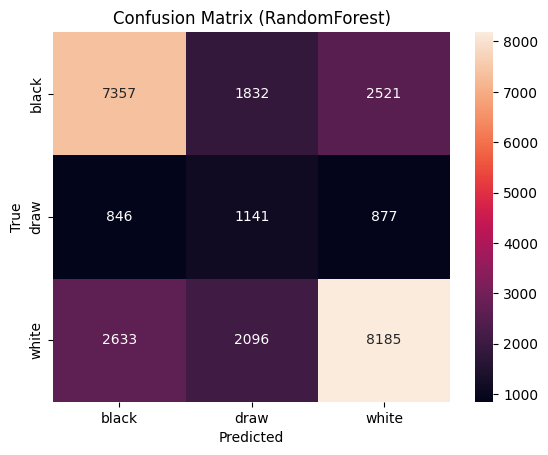

['best_rf_model.pkl']

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numerical),
    ]
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(
                class_weight=class_weights, random_state=42),
        ),
    ]
)

param_grid_rf = {
    "classifier__n_estimators": [100],
    "classifier__max_depth": [None, 3, 5],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2"],
}

grid_search_rf = GridSearchCV(
    rf_pipeline, param_grid_rf, cv=5, scoring="f1_macro", n_jobs=-1
)
grid_search_rf.fit(X_train_balanced_raw, y_train_balanced)

y_pred_train_rf = grid_search_rf.predict(X_train_balanced_raw)
y_pred_test_rf = grid_search_rf.predict(X_test_raw)

print("RF best params:", grid_search_rf.best_params_)
print(
    "RF TRAIN\n",
    classification_report(y_train_balanced, y_pred_train_rf,
                          target_names=le.classes_),
)
print(
    "RF TEST\n",
    classification_report(y_test_enc, y_pred_test_rf,
                          target_names=le.classes_),
)

cm_rf = confusion_matrix(y_test_enc, y_pred_test_rf)
sns.heatmap(cm_rf, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (RandomForest)")
plt.show()

joblib.dump(grid_search_rf.best_estimator_, "best_rf_model.pkl")

Black_Time_To_Move_q80                0.145436
White_Time_To_Move_q80                0.142194
White_Rating                          0.096589
Black_Rating                          0.093879
black_eval_q80                        0.073025
Diff_Rating                           0.072227
white_eval_q80                        0.070173
Black_Time_Remaining                  0.045319
White_Time_Remaining                  0.043909
Total_Time_Increment_Group_0 sec      0.005007
Speed_bullet                          0.004384
Speed_blitz                           0.004349
Speed_rapid                           0.004059
Speed_classical                       0.003456
Opening_ECO_B12                       0.003320
Opening_ECO_A45                       0.003134
Opening_ECO_D02                       0.003018
Total_Time_Increment_Group_4–8 sec    0.002964
Opening_ECO_B10                       0.002917
Opening_ECO_B23                       0.002717
dtype: float64


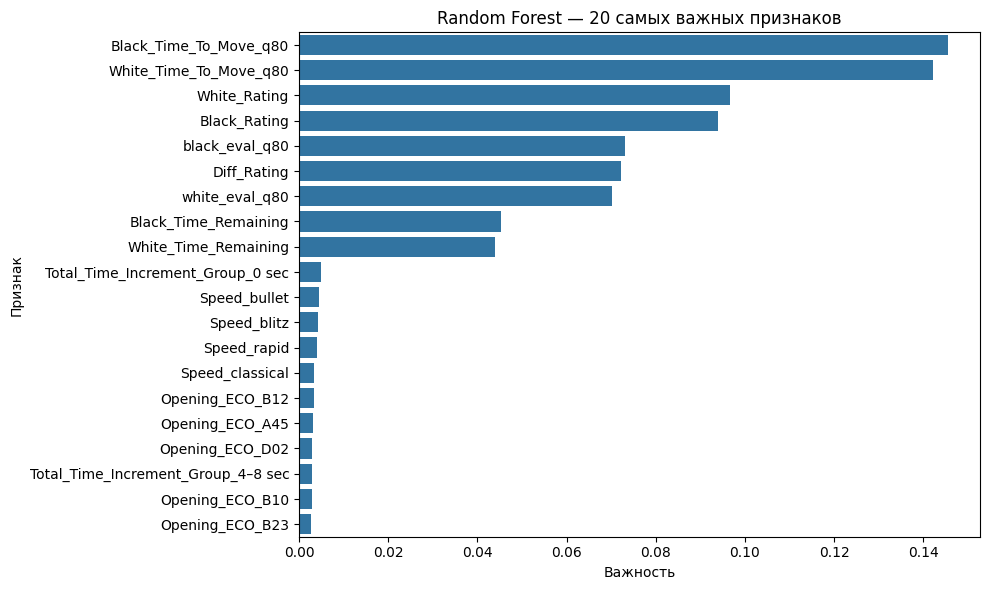

In [26]:
best_rf = grid_search_rf.best_estimator_
ohe = best_rf.named_steps["preprocessor"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(categorical)
feature_names = list(cat_names) + numerical

rf_importances = pd.Series(
    best_rf.named_steps["classifier"].feature_importances_,
    index=feature_names,
)
top20_features = rf_importances.sort_values(ascending=False).head(20)
print(top20_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=top20_features.values, y=top20_features.index)
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.title("Random Forest — 20 самых важных признаков")
plt.tight_layout()
plt.show()

## CatBoost Model

0:	learn: 1.0913975	test: 1.0921900	best: 1.0921900 (0)	total: 126ms	remaining: 1m 28s
100:	learn: 0.9246120	test: 0.9396577	best: 0.9396577 (100)	total: 14.8s	remaining: 1m 28s
200:	learn: 0.9025768	test: 0.9259533	best: 0.9258914 (199)	total: 28.5s	remaining: 1m 10s
300:	learn: 0.8895745	test: 0.9205473	best: 0.9205473 (300)	total: 40.9s	remaining: 54.2s
400:	learn: 0.8797681	test: 0.9186604	best: 0.9185140 (393)	total: 52.6s	remaining: 39.2s
500:	learn: 0.8715241	test: 0.9182615	best: 0.9182163 (473)	total: 1m 6s	remaining: 26.4s
600:	learn: 0.8634558	test: 0.9172350	best: 0.9171717 (572)	total: 1m 17s	remaining: 12.8s
699:	learn: 0.8562432	test: 0.9171120	best: 0.9168292 (684)	total: 1m 28s	remaining: 0us

bestTest = 0.9168291643
bestIteration = 684

Shrink model to first 685 iterations.
CB best params: {'learning_rate': np.float64(0.15), 'l2_leaf_reg': 5, 'iterations': 700, 'depth': 4}
CB TRAIN
               precision    recall  f1-score   support

       black       0.73      0.

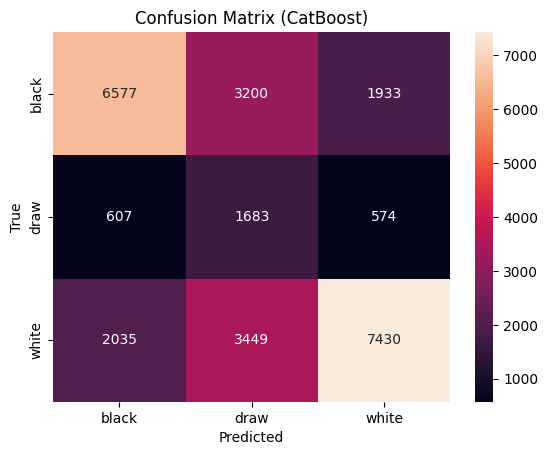

['catboost_best.pkl']

In [19]:
cat_features_idx = [X_train_balanced_raw.columns.get_loc(
    col) for col in categorical]

param_dist_cb = {
    "depth": [3, 4],
    "learning_rate": np.linspace(0.03, 0.15, 5),
    "iterations": [500, 700, 1000],
    "l2_leaf_reg": [3, 5, 7],
}

cv_cb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cb_search = CatBoostClassifier(
    loss_function="MultiClass",
    random_state=42,
    class_weights=list(dict(sorted(class_weights.items())).values()),
    verbose=0,
)

random_search_cb = RandomizedSearchCV(
    cb_search,
    param_dist_cb,
    n_iter=25,
    scoring="f1_macro",
    cv=cv_cb,
    refit=False,
    # n_jobs=-1,
    random_state=42,
)

random_search_cb.fit(X_train_balanced_raw, y_train_balanced,
                     cat_features=cat_features_idx)
best_params_cb = random_search_cb.best_params_

X_train_inner_raw, X_valid_raw, y_train_inner, y_valid_inner = train_test_split(
    X_train_balanced_raw,
    y_train_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_train_balanced,
)

train_pool = Pool(X_train_inner_raw, y_train_inner,
                  cat_features=cat_features_idx)
valid_pool = Pool(X_valid_raw, y_valid_inner, cat_features=cat_features_idx)

final_cb = CatBoostClassifier(
    **best_params_cb,
    loss_function="MultiClass",
    random_state=42,
    class_weights=list(dict(sorted(class_weights.items())).values()),
    early_stopping_rounds=50,
    verbose=100,
)

final_cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)

y_pred_train_cb = final_cb.predict(X_train_balanced_raw)
y_pred_test_cb = final_cb.predict(X_test_raw)

print("CB best params:", best_params_cb)
print(
    "CB TRAIN\n",
    classification_report(y_train_balanced, y_pred_train_cb,
                          target_names=le.classes_),
)
print(
    "CB TEST\n",
    classification_report(y_test_enc, y_pred_test_cb,
                          target_names=le.classes_),
)

cm_cb = confusion_matrix(y_test_enc, y_pred_test_cb)
sns.heatmap(cm_cb, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (CatBoost)")
plt.show()

final_cb.save_model("catboost_best.cbm")
joblib.dump(final_cb, "catboost_best.pkl")

Black_Time_To_Move_q80        22.817703
White_Time_To_Move_q80        22.626578
White_Rating                  11.307790
Black_Rating                  11.142482
black_eval_q80                 6.092640
Black_Time_Remaining           5.118188
White_Time_Remaining           4.875187
Diff_Rating                    4.438773
Speed                          3.756376
Opening_ECO                    3.187819
white_eval_q80                 3.114736
Total_Time_Increment_Group     1.521728
dtype: float64


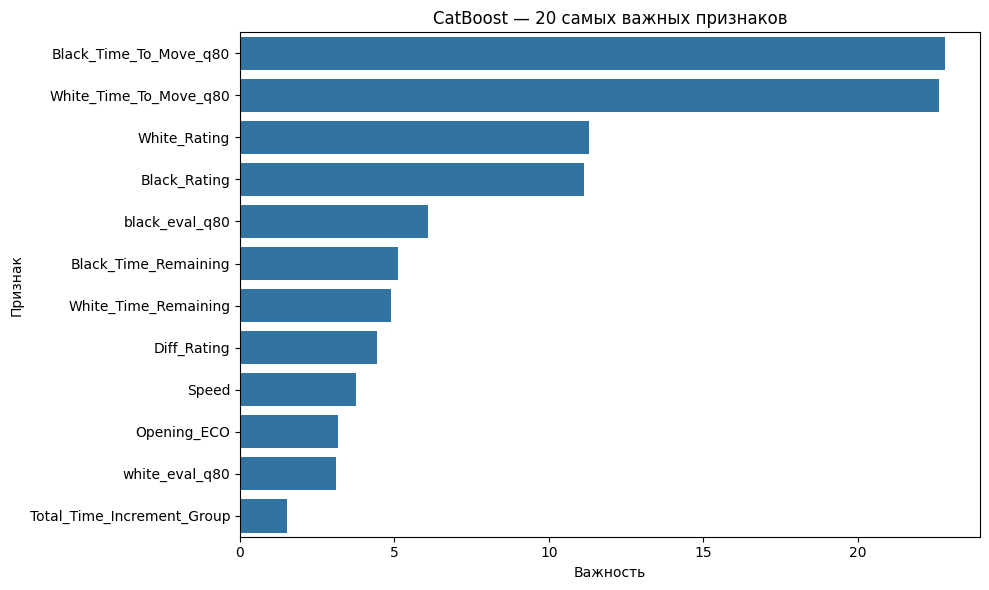

In [25]:
cb_importances = final_cb.get_feature_importance(type="FeatureImportance")
cb_importance_series = pd.Series(
    cb_importances, index=X_train_balanced_raw.columns)
top20_features = cb_importance_series.sort_values(ascending=False).head(20)
print(top20_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=top20_features.values, y=top20_features.index)
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.title("CatBoost — 20 самых важных признаков")
plt.tight_layout()
plt.show()

## Stacking

In [21]:
class CBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_features, **params):
        self.cat_features = cat_features
        self.params = params
        self.model = CatBoostClassifier(**params)

    def fit(self, X, y):
        self.model.fit(X, y, cat_features=self.cat_features, verbose=0)
        self.classes_ = self.model.classes_
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

STACK TRAIN
               precision    recall  f1-score   support

       black       0.78      0.64      0.70     27322
        draw       0.30      0.78      0.43      6682
       white       0.80      0.65      0.72     30134

    accuracy                           0.66     64138
   macro avg       0.63      0.69      0.62     64138
weighted avg       0.74      0.66      0.68     64138

STACK TEST
               precision    recall  f1-score   support

       black       0.72      0.59      0.65     11710
        draw       0.21      0.54      0.30      2864
       white       0.75      0.61      0.67     12914

    accuracy                           0.59     27488
   macro avg       0.56      0.58      0.54     27488
weighted avg       0.68      0.59      0.62     27488



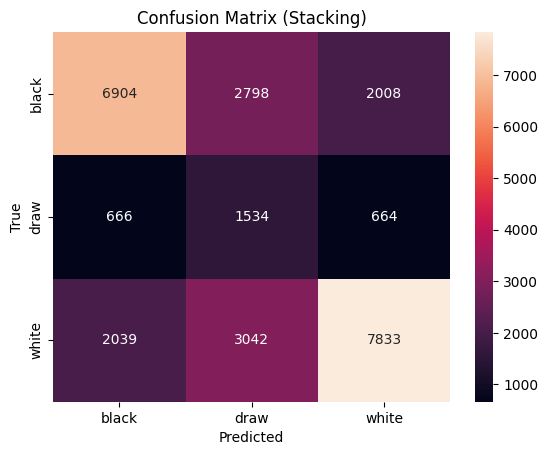

['stacking_model.pkl']

In [22]:
rf_best = grid_search_rf.best_estimator_

cb_base = CBWrapper(
    cat_features=cat_features_idx,
    thread_count=4,
    **best_params_cb,
    loss_function="MultiClass",
    random_state=42,
    class_weights=list(dict(sorted(class_weights.items())).values()),
    early_stopping_rounds=50,
    verbose=0,
)

logreg_meta = LogisticRegression(max_iter=1000, class_weight=class_weights)

stack_model = StackingClassifier(
    estimators=[("rf", rf_best), ("cb", cb_base)],
    final_estimator=logreg_meta,
    cv=3,
    n_jobs=-1,
    passthrough=False,
)

stack_model.fit(X_train_balanced_raw, y_train_balanced)

y_pred_train_stack = stack_model.predict(X_train_balanced_raw)
y_pred_test_stack = stack_model.predict(X_test_raw)

print(
    "STACK TRAIN\n",
    classification_report(
        y_train_balanced, y_pred_train_stack, target_names=le.classes_),
)
print(
    "STACK TEST\n",
    classification_report(y_test_enc, y_pred_test_stack,
                          target_names=le.classes_),
)

cm_stack = confusion_matrix(y_test_enc, y_pred_test_stack)
sns.heatmap(cm_stack, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Stacking)")
plt.show()

joblib.dump(stack_model, "stacking_model.pkl")

Вклад базовых моделей в стекинге:
cb    10.495885
rf     5.439760
dtype: float64


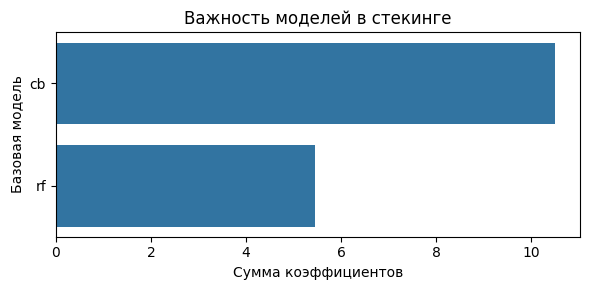

In [24]:
logreg = stack_model.final_estimator_
coef = np.abs(logreg.coef_)

n_base_models = len(stack_model.estimators_)
n_total_features = coef.shape[1]
features_per_model = n_total_features // n_base_models

model_importance = {}
for i, name in enumerate(stack_model.named_estimators_.keys()):
    sl = slice(i * features_per_model, (i + 1) * features_per_model)
    model_importance[name] = coef[:, sl].sum()

importance_series = pd.Series(model_importance).sort_values(ascending=False)
print("Вклад базовых моделей в стекинге:")
print(importance_series)

plt.figure(figsize=(6, 3))
sns.barplot(x=importance_series.values, y=importance_series.index)
plt.xlabel("Сумма коэффициентов")
plt.ylabel("Базовая модель")
plt.title("Важность моделей в стекинге")
plt.tight_layout()
plt.show()